# **_Image Forgery Detection using Recompression_**


## About the dataset

## Authentic images:

1. Au_ani_00001.jpg
   Au: Authentic
   ani: animal category
2. Other categories: arc (architecture), art, cha (characters), ind (indoor), nat (nature), pla (plants), txt (texture)

## Tampering images

a. Spliced image

        Tp_D_CRN_S_N_cha00063_art00014_11818.jpg

- Tp: Tampering
- D: Different (means the tampered region was copied from the different image)
- Next 5 letters stand for the techniques they used to create the images. Unfortunately, I don't remember exactly.
- cha00063: the source image
- art00014: the target image
- 11818: tampered image ID

b. Copy-move images

        Tp_S_NRN_M_N_pla00020_pla00020_10988.jpg

- Tp: Tampering
- S: Same (means the tampered region was copied from the same image)
- And the rest is similar to case a.

If you use the groundtruth dataset for a scientific publication, please cite the following papers:

- CASIA dataset

        @inproceedings{Dong2013,
        doi = {10.1109/chinasip.2013.6625374},
        url = {https://doi.org/10.1109/chinasip.2013.6625374},
        year = {2013},
        month = jul,
        publisher = {{IEEE}},
        author = {Jing Dong and Wei Wang and Tieniu Tan},
        title = {{CASIA} Image Tampering Detection Evaluation Database},
        booktitle = {2013 {IEEE} China Summit and International Conference on Signal and Information Processing}
        }

- CASIA groundtruth dataset

       @article{pham2019hybrid,
       title={Hybrid Image-Retrieval Method for Image-Splicing Validation},
       author={Pham, Nam Thanh and Lee, Jong-Weon and Kwon, Goo-Rak and Park, Chun-Su},
       journal={Symmetry},
       volume={11},
       number={1},
       pages={83},
       year={2019},
       publisher={Multidisciplinary Digital Publishing Institute}
       }


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import os
import joblib
PATH = '../dataset/CASIA2/'


In [2]:

# PATH_TP='./dataset/CASIA2/Tp/'
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH+label))
    for img_file in os.listdir(PATH+label):
        img_lst.append(PATH+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()


,img,label
0,../dataset/CASIA2/Au/Au_ani_00001.jpg,Au
1,../dataset/CASIA2/Au/Au_ani_00002.jpg,Au
2,../dataset/CASIA2/Au/Au_ani_00003.jpg,Au
3,../dataset/CASIA2/Au/Au_ani_00004.jpg,Au
4,../dataset/CASIA2/Au/Au_ani_00005.jpg,Au


In [3]:
df.label.value_counts()


Au    7491
Tp    5123
Name: label, dtype: int64

In [4]:
# def size(x):
#     return plt.imread(x).shape


# df['size'] = df['img'].apply(size)


In [5]:
# print(df['size'].head(20))
# print(df['size'].tail(20))
# # df.tail()


In [6]:
path_resaved = '../dataset/resaved/'


def difference(path):
    filename = path
    # print(path)
    resaved_name = filename.split('.')[-2]+'_resaved.jpg'
    # print(resaved_name)
    resaved_name = path_resaved+resaved_name.split('/')[-1]
    org = Image.open(filename).convert('RGB')
    org.save(resaved_name, 'JPEG', quality=90)
    resaved = Image.open(resaved_name)
    diff = ImageChops.difference(org, resaved)
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    diff = ImageEnhance.Brightness(diff).enhance(scale)
    # diff
    return diff


In [10]:
from keras.utils.np_utils import to_categorical
from pylab import *
X = []
y = []

for index, row in df.iterrows():
    x = array(difference(row[0]).resize((128, 128))).flatten()/255.0
    X.append(x)
    if row[1] == 'Au':
        y.append(0)
    else:
        y.append(1)

X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

Y = to_categorical(y, 2)


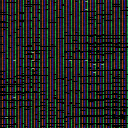

In [11]:
# x=difference(df['img'][9000]).resize((128, 128))
# # .flatten()/255.0
# x=array(x)
# print(x.shape)
# x.flatten().shape
# x
Image.fromarray(X[0], 'RGB')
# Image.fromarray(X[10].reshape((128,128,3)),'RGB')


In [12]:
import joblib

joblib.dump(X, 'X_comp_diff_org.joblib')
joblib.dump(y, 'y_comp_diff_org.joblib')


['y_comp_diff_org.joblib']

In [13]:
# import joblib
# X=joblib.load('./X_comp_diff_org.joblib')
# y=joblib.load('./y_comp_diff_org.joblib')


In [14]:
# y=np.array(y)
# type(y)


In [15]:
# print(X.shape)
# y=y.reshape((-1,1))
# y.shape


### Train-Test Split


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=0, shuffle=True)


In [23]:
print(X_train.shape, X_test.shape)
print(type(Y))


(11352, 128, 128, 3) (1262, 128, 128, 3)
<class 'numpy.ndarray'>


### Model Building


In [50]:
def build_model(activation='sigmoid'):

    model = tf.keras.Sequential()
    # input layer
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32,
              input_shape=[128, 128, 3], activation='relu'))

    # hidden layers
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(5, 5), activation='relu'))
    # pooling
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=2, padding='valid', strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(.25))
    # flatten
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(.50))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(.50))

    # output layer
    model.add(tf.keras.layers.Dense(2, activation=activation))
    return model


In [51]:
model = build_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 32)      25632     
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 59, 59, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 111392)            0         
                                                      

In [42]:
epoch = 20
batch_size = 33
cal1 = tf.keras.callbacks.ModelCheckpoint(
    save_best_only=True, filepath='ann.h5')
cal2 = tf.keras.callbacks.EarlyStopping(patience=4)
#  optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
# model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(
    X_test, y_test), batch_size=batch_size, epochs=epoch, callbacks=[cal1, cal2])
history = history.history


Epoch 1/20
344/344 [==============================] - 546s 2s/step - loss: 0.2257 - accuracy: 0.9064 - val_loss: 0.3606 - val_accuracy: 0.8851
Epoch 2/20
344/344 [==============================] - 536s 2s/step - loss: 0.2108 - accuracy: 0.9142 - val_loss: 0.3437 - val_accuracy: 0.8796
Epoch 3/20
344/344 [==============================] - 543s 2s/step - loss: 0.1973 - accuracy: 0.9162 - val_loss: 0.4531 - val_accuracy: 0.8875
Epoch 4/20
344/344 [==============================] - 540s 2s/step - loss: 0.1849 - accuracy: 0.9212 - val_loss: 0.4237 - val_accuracy: 0.8859
Epoch 5/20
344/344 [==============================] - 533s 2s/step - loss: 0.1675 - accuracy: 0.9261 - val_loss: 0.5252 - val_accuracy: 0.8724
Epoch 6/20
344/344 [==============================] - 525s 2s/step - loss: 0.1605 - accuracy: 0.9304 - val_loss: 0.4852 - val_accuracy: 0.8796


In [43]:
model.save("model_sigmoid.h5")


In [44]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)

# confusion_matrix(y_pred, y_test)
y_pred


40/40 [==============================] - 6s 137ms/step


array([[2.2586727e-01, 7.2307569e-01],
       [5.6561228e-02, 8.6671513e-01],
       [1.0000000e+00, 3.5814014e-09],
       ...,
       [1.0000000e+00, 6.0439520e-09],
       [1.0000000e+00, 0.0000000e+00],
       [9.9999017e-01, 3.5228682e-06]], dtype=float32)

In [45]:
y_pred = np.where(y_pred >= 0.5, 1, 0)


In [46]:
y_pred = y_pred.astype('float32')
y_pred = np.argmax(y_pred, axis=1)


In [47]:
confusion_matrix(y_pred=y_pred, y_true=y_test.argmax(axis=1))


array([[634,  96],
       [ 60, 472]], dtype=int64)

Text(0, 0.5, 'loss')

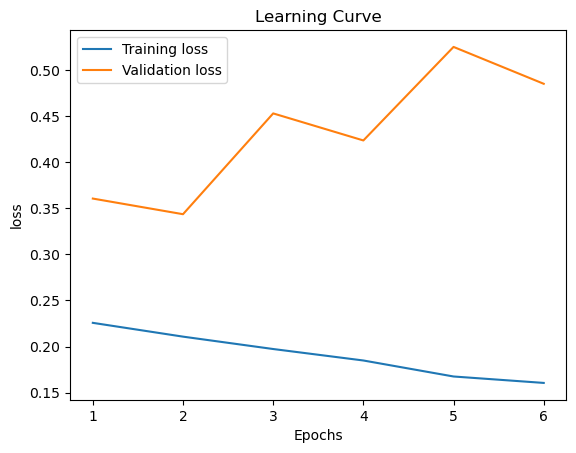

In [49]:
plt.plot(range(1, 7), history['loss'])
plt.plot(range(1, 7), history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')


In [52]:
model_softmax = build_model('softmax')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 122, 122, 32)      25632     
                                                                 
 conv2d_8 (Conv2D)           (None, 118, 118, 32)      25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 59, 59, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 59, 59, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 111392)            0         
                                                      

In [ ]:
epoch = 20
batch_size = 33
cal1 = tf.keras.callbacks.ModelCheckpoint(
    save_best_only=True, filepath='model_softmax.h5')
cal2 = tf.keras.callbacks.EarlyStopping(patience=4)
#  optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
# model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(
    X_test, y_test), batch_size=batch_size, epochs=epoch, callbacks=[cal1, cal2])
history = history.history